In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cart_size_calculator import *

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

Overall Mean Cart Size: 14.73
Median Cart Size: 14.0
Std Dev of Cart Size: 7.19
Mean Cart Size (Holiday): 14.76
Mean Cart Size (Normal): 8.64


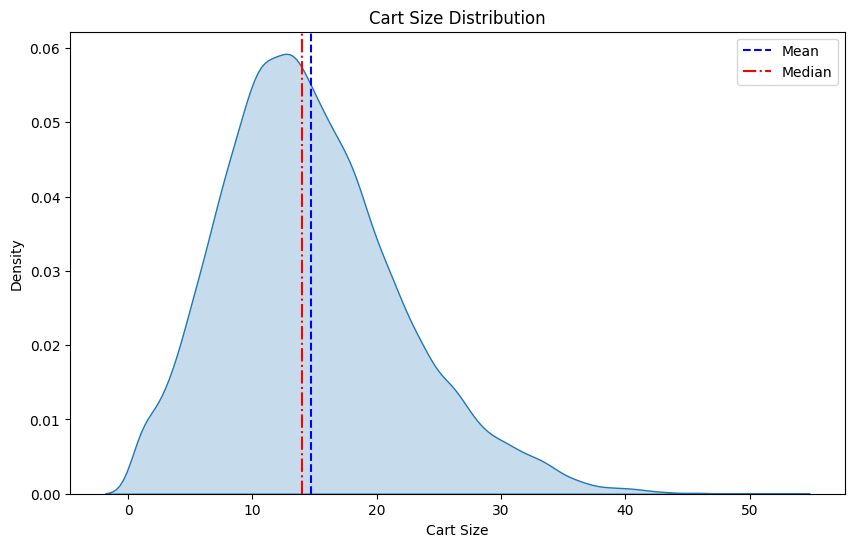

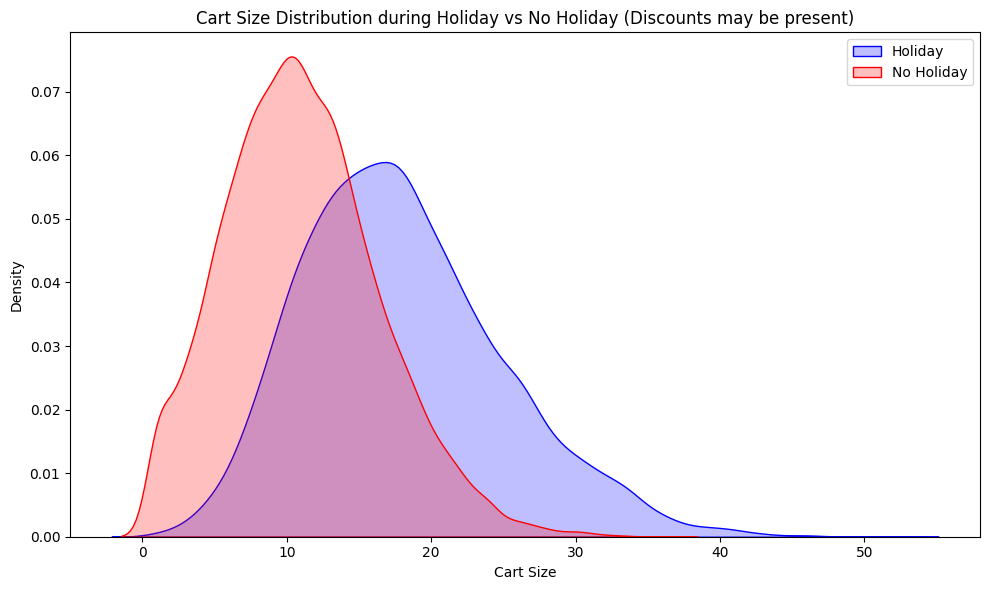

In [2]:
# Load the data

df = generate_cart_dataset(25000, "2024-01-01", "2025-01-01", base_mean=8)

In [3]:
df.head()

,date,income,family_size,store_location,discount_flag,holiday,cart_size
0,2024-08-14,150000,3,High,1,Normal Day,8
1,2024-08-15,45159,4,Low,1,Normal Day,11
2,2024-07-06,77375,1,High,1,Independence Day,16
3,2024-09-05,73953,4,Medium,1,Labor Day,20
4,2024-01-13,74511,4,Medium,1,Normal Day,13


# Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            25000 non-null  datetime64[ns]
 1   income          25000 non-null  int32         
 2   family_size     25000 non-null  int32         
 3   store_location  25000 non-null  object        
 4   discount_flag   25000 non-null  int64         
 5   holiday         25000 non-null  object        
 6   cart_size       25000 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(2)
memory usage: 1.1+ MB


In [5]:
df.describe().round(2)

,date,income,family_size,discount_flag,cart_size
count,25000,25000.00,25000.00,25000.00,25000.00
mean,2024-07-02 01:00:46.079999744,71011.48,3.03,1.00,14.73
min,2023-12-30 00:00:00,35000.00,1.00,0.00,1.00
25%,2024-03-30 00:00:00,52734.75,2.00,1.00,10.00
50%,2024-06-29 00:00:00,67010.50,3.00,1.00,14.00
75%,2024-10-05 00:00:00,84658.50,4.00,1.00,19.00
max,2025-01-01 00:00:00,150000.00,6.00,1.00,52.00
std,NaN,24652.19,1.41,0.06,7.19


In [6]:
df.describe(include='object')

,store_location,holiday
count,25000,25000
unique,3,17
top,Medium,Normal Day
freq,8363,11645


# Distribution of cart size

In [7]:
df['holiday'].unique()

array(['Normal Day', 'Independence Day', 'Labor Day', "Valentine's Day",
       'Christmas', 'Easter', 'Memorial Day', 'Halloween', 'Veterans Day',
       'New Year', "Father's Day", 'Thanksgiving & Black Friday',
       'Cinco de Mayo', "St. Patrick's Day", 'Superbowl',
       'Back to School', "Mother's Day"], dtype=object)

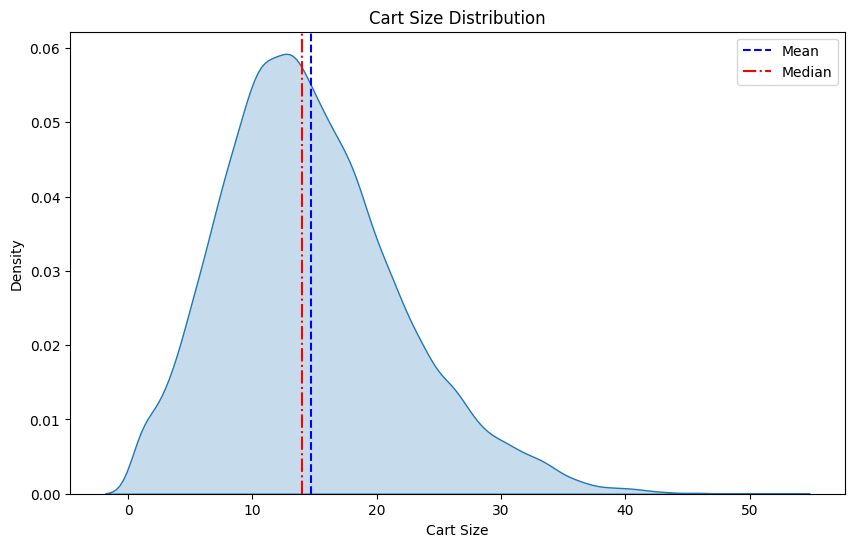

In [8]:
# KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['cart_size'], fill=True)

# Add mean and median lines
plt.axvline(df['cart_size'].mean(), linestyle='--', color='blue', label='Mean')
plt.axvline(df['cart_size'].median(), linestyle='-.', color='red', label='Median')

# Labels and title
plt.xlabel('Cart Size')
plt.ylabel('Density')
plt.title('Cart Size Distribution')
plt.legend()
plt.show()


# Cart size variation based on holiday

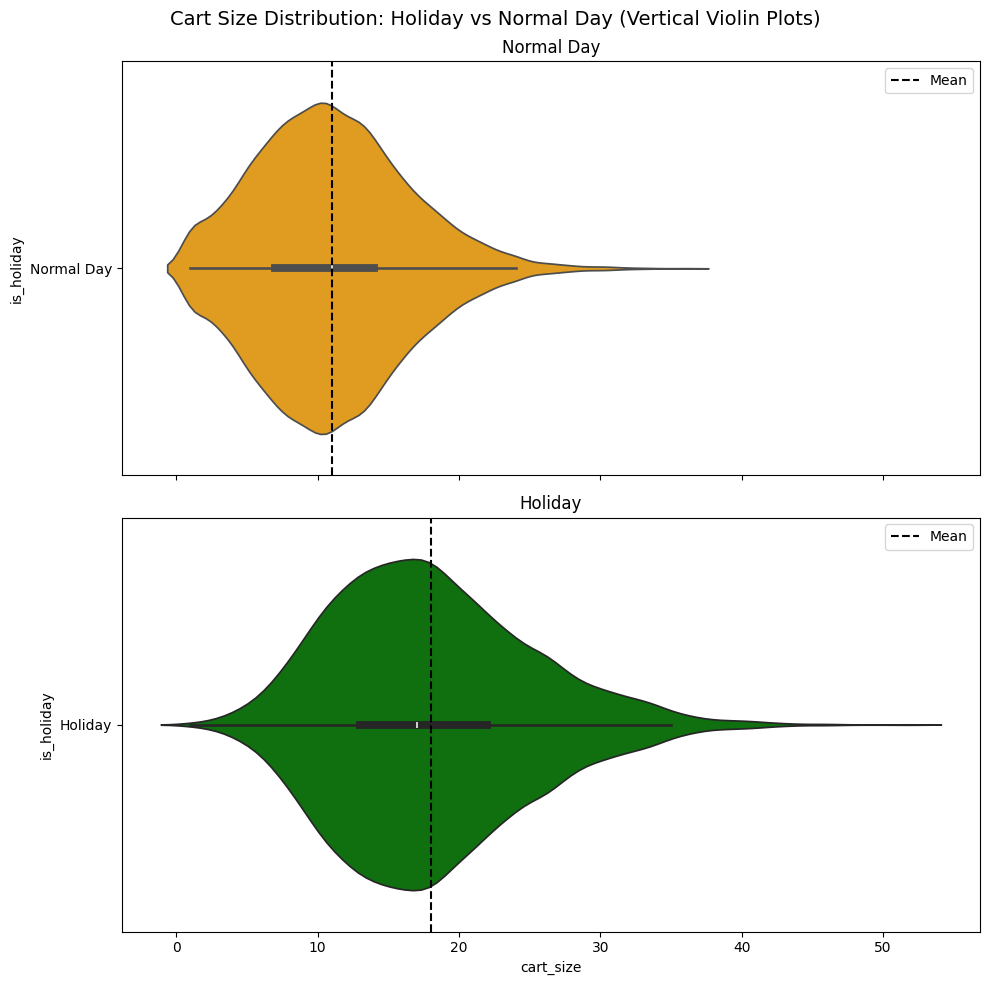

In [9]:
# Create a new column to classify Holiday vs Normal Day
df['is_holiday'] = df['holiday'].apply(lambda x: 'Holiday' if x != 'Normal Day' else 'Normal Day')

# Create subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Normal Day plot
normal_day_data = df[df['is_holiday'] == 'Normal Day']
sns.violinplot(
    data=normal_day_data,
    x='cart_size',
    y='is_holiday',
    orient='h',
    ax=axes[0],
    color='orange',
    inner='box'
)
axes[0].axvline(normal_day_data['cart_size'].mean(), color='black', linestyle='--', label='Mean')
axes[0].set_title('Normal Day')
axes[0].legend()

# Holiday plot
holiday_data = df[df['is_holiday'] == 'Holiday']
sns.violinplot(
    data=holiday_data,
    x='cart_size',
    y='is_holiday',
    orient='h',
    ax=axes[1],
    color='green',
    inner='box'
)
axes[1].axvline(holiday_data['cart_size'].mean(), color='black', linestyle='--', label='Mean')
axes[1].set_title('Holiday')
axes[1].legend()

# Overall layout
fig.suptitle('Cart Size Distribution: Holiday vs Normal Day (Vertical Violin Plots)', fontsize=14)
plt.tight_layout()
plt.show()


# Effect of holidays on Cart size 

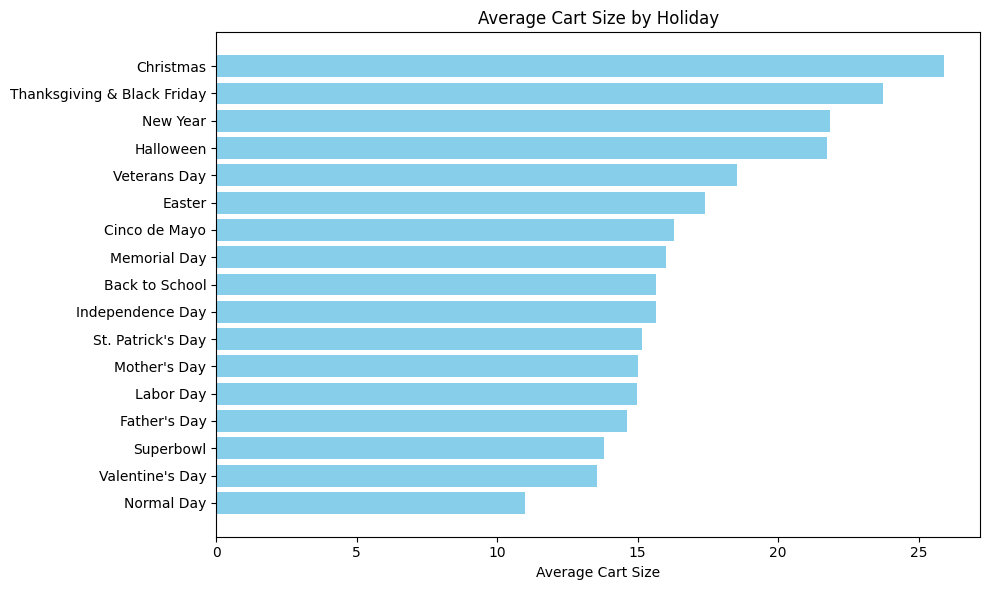

In [10]:
# Group and sort
holiday_grp = df.groupby("holiday")["cart_size"].mean().sort_values(ascending=False)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(holiday_grp.index, holiday_grp.values, color='skyblue')
plt.xlabel('Average Cart Size')
plt.title('Average Cart Size by Holiday')
plt.gca().invert_yaxis()  # To show highest at the top
plt.tight_layout()
plt.show()

# Income Distribution

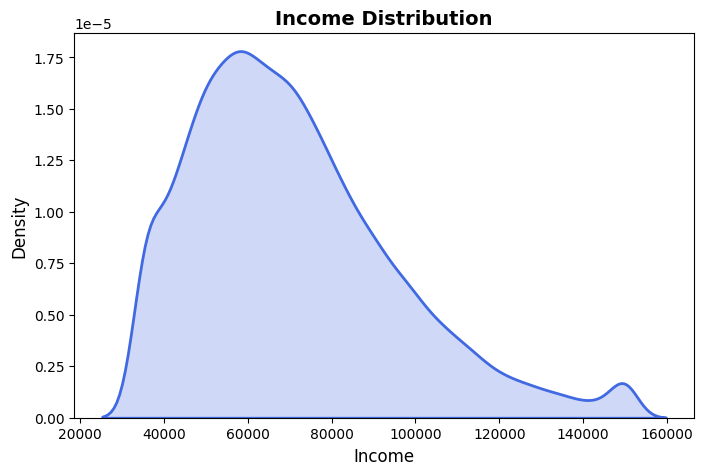

In [11]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df.income, fill=True, color="royalblue", linewidth=2)
plt.xlabel("Income", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Income Distribution", fontsize=14, fontweight="bold")

plt.show()

# Family size vs cart sizes

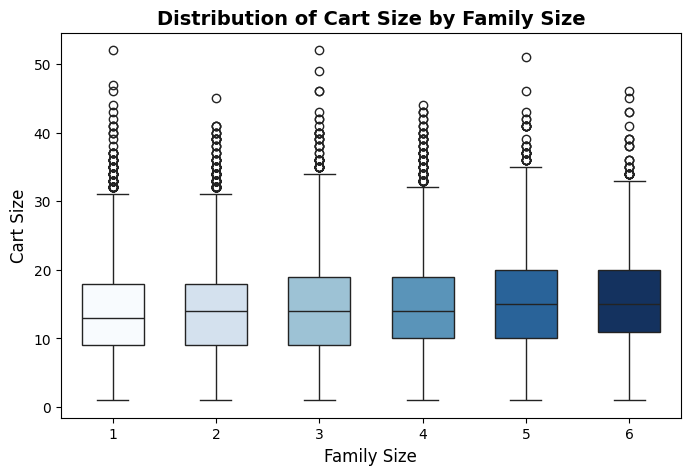

In [12]:
plt.figure(figsize=(8, 5))

# Create the box plot
sns.boxplot(x=df["family_size"], y=df["cart_size"], hue=df["family_size"], legend=False, palette="Blues", width=0.6)

# Add labels and title
plt.xlabel("Family Size", fontsize=12)
plt.ylabel("Cart Size", fontsize=12)
plt.title("Distribution of Cart Size by Family Size", fontsize=14, fontweight="bold")

plt.show()

# Cart size vs discount

<Figure size 800x500 with 0 Axes>

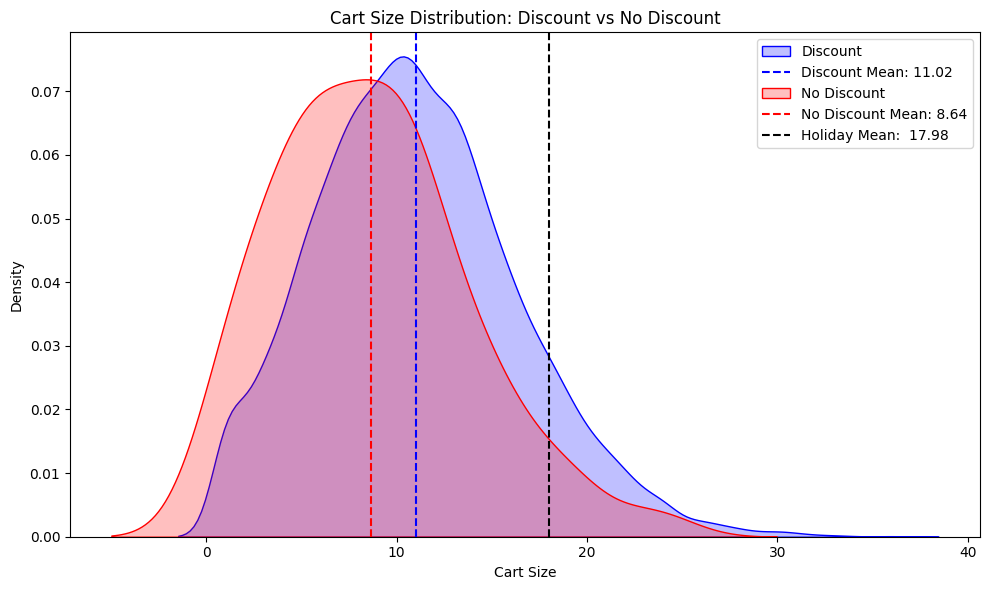

In [13]:
plt.figure(figsize=(8, 5))

df_discount = df[(df["holiday"] == "Normal Day")]

# Create subsets
discount_cart = df_discount[df_discount["discount_flag"] == 1]["cart_size"]
no_discount_cart = df_discount[df_discount["discount_flag"] == 0]["cart_size"]

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(discount_cart, label='Discount', fill=True, color='blue')
plt.axvline(discount_cart.mean(), color='blue', linestyle='--', label=f'Discount Mean: {discount_cart.mean():.2f}')

sns.kdeplot(no_discount_cart, label='No Discount', fill=True, color='red')
plt.axvline(no_discount_cart.mean(), color='red', linestyle='--', label=f'No Discount Mean: {no_discount_cart.mean():.2f}')

plt.axvline(holiday_data['cart_size'].mean(), color='black', linestyle='--', label=f'Holiday Mean: {holiday_data['cart_size'].mean(): .2f}')

# Labels and title
plt.xlabel('Cart Size')
plt.ylabel('Density')
plt.title('Cart Size Distribution: Discount vs No Discount')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
df = df.drop('is_holiday', axis=1)

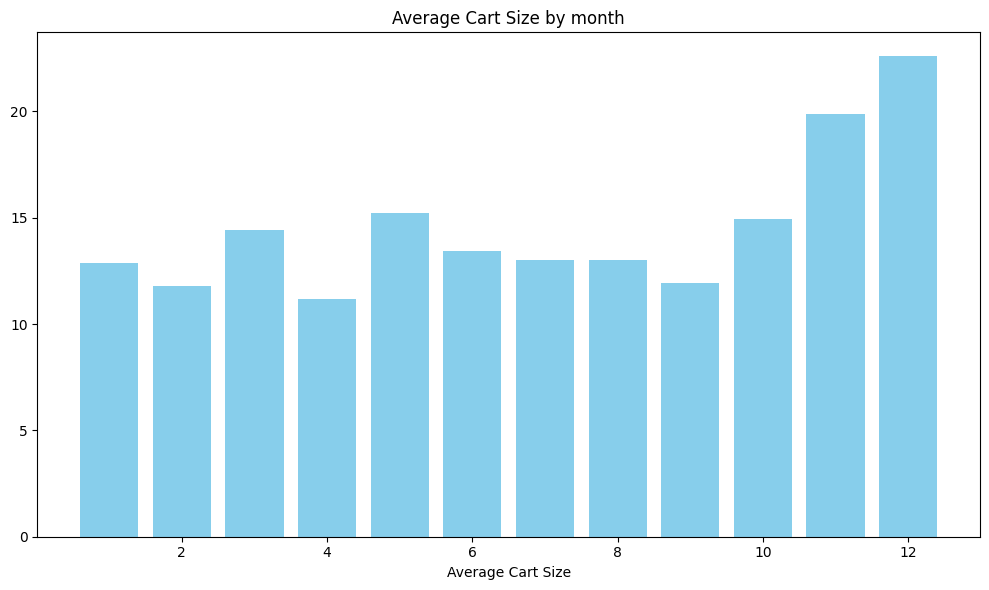

In [15]:
# Get month name
df['month'] = df['date'].dt.month

# lets avg by month and see if there is any trend across months 
month_grp = df.groupby("month")["cart_size"].mean()

plt.figure(figsize=(10, 6))
plt.bar(month_grp.index, month_grp.values, color='skyblue')
plt.xlabel('Average Cart Size')
plt.title('Average Cart Size by month')
plt.tight_layout()
plt.show()

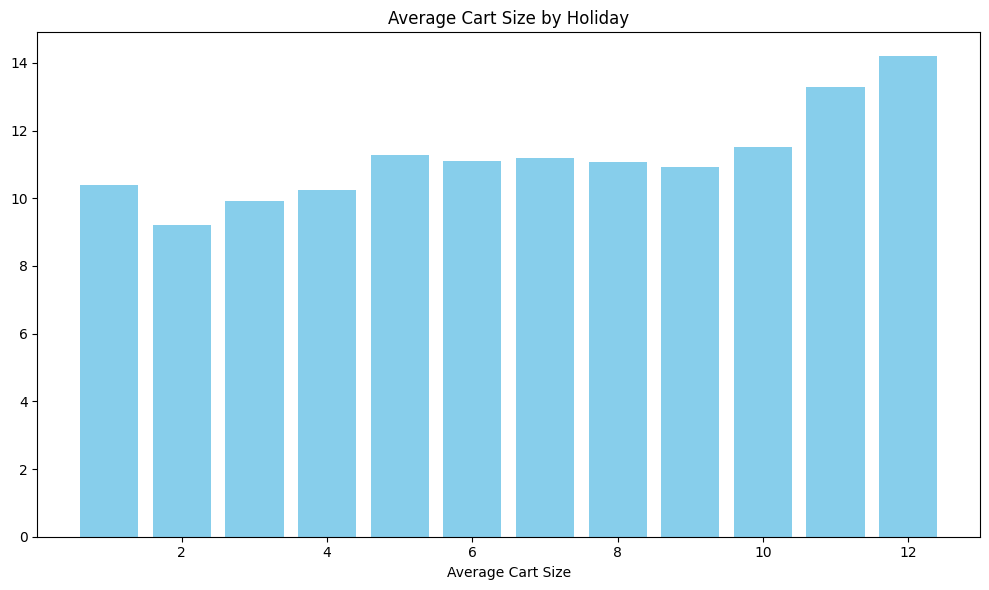

In [16]:
# Get month name
df['month'] = df['date'].dt.month

no_holidays = df[df["holiday"] == "Normal Day"]
# lets avg by month and see if there is any trend across months 
month_grp = no_holidays.groupby("month")["cart_size"].mean()

plt.figure(figsize=(10, 6))
plt.bar(month_grp.index, month_grp.values, color='skyblue')
plt.xlabel('Average Cart Size')
plt.title('Average Cart Size by Holiday')
plt.tight_layout()
plt.show()

There doesn't seem to be a linear change across the months and November and December seems to have high average because of the discounts and holidays present

In [17]:
# drop month 
df = df.drop("month", axis=1)

# Correlation matrix

<Axes: >

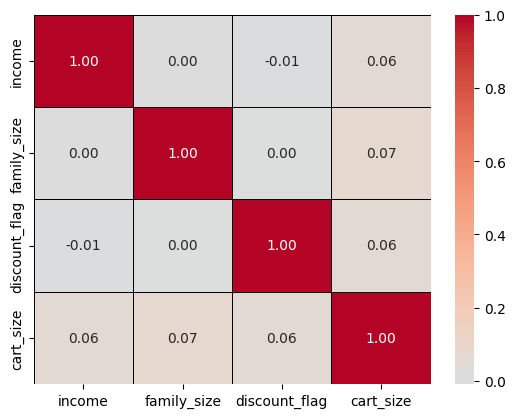

In [18]:
sns.heatmap(data=df.corr(numeric_only=True),
           annot=True,
           fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')

There is no multi correlation so let's move to model prep

# Model Prep

In [19]:
df.head()

,date,income,family_size,store_location,discount_flag,holiday,cart_size
0,2024-08-14,150000,3,High,1,Normal Day,8
1,2024-08-15,45159,4,Low,1,Normal Day,11
2,2024-07-06,77375,1,High,1,Independence Day,16
3,2024-09-05,73953,4,Medium,1,Labor Day,20
4,2024-01-13,74511,4,Medium,1,Normal Day,13


In [20]:
# Lets remove date

df = df.drop('date', axis=1)

In [21]:
# get dummies 

df_1 = pd.get_dummies(df, drop_first=True, dtype=int)
df_1.head()

,income,family_size,discount_flag,cart_size,store_location_Low,store_location_Medium,holiday_Christmas,holiday_Cinco de Mayo,holiday_Easter,holiday_Father's Day,...,holiday_Labor Day,holiday_Memorial Day,holiday_Mother's Day,holiday_New Year,holiday_Normal Day,holiday_St. Patrick's Day,holiday_Superbowl,holiday_Thanksgiving & Black Friday,holiday_Valentine's Day,holiday_Veterans Day
0,150000,3,1,8,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,45159,4,1,11,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,77375,1,1,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,73953,4,1,20,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,74511,4,1,13,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
# reorder cart_size to the end

col = df_1.pop('cart_size')
df_1['cart_size'] = col
df_1.head(2)

,income,family_size,discount_flag,store_location_Low,store_location_Medium,holiday_Christmas,holiday_Cinco de Mayo,holiday_Easter,holiday_Father's Day,holiday_Halloween,...,holiday_Memorial Day,holiday_Mother's Day,holiday_New Year,holiday_Normal Day,holiday_St. Patrick's Day,holiday_Superbowl,holiday_Thanksgiving & Black Friday,holiday_Valentine's Day,holiday_Veterans Day,cart_size
0,150000,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,8
1,45159,4,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11


In [23]:
# Split the variables

X = df_1.drop('cart_size', axis=1)
X = X.drop('income', axis=1)
y = df_1['cart_size']

In [24]:
# test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [25]:
def model_fit(model, train_X, test_X, train_y, test_y):
    pipe = Pipeline([
        ("scalar", StandardScaler()),
        ("regression", model)
    ])

    pipe.fit(train_X, train_y)

    # Predict on test set
    prediction = pipe.predict(test_X)
    print(f"{model.__class__.__name__} Prediction Sample: {prediction[:4]}")

    print("Metrics")
    print(f"MAE: {mean_absolute_error(test_y, prediction):.2f}")
    print(f"MSE: {mean_squared_error(test_y, prediction):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, prediction)):.3f}")

    # Residual plot
    residuals = test_y - prediction
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual Distribution - {model.__class__.__name__}")
    plt.axvline(x=0, color='red', linestyle='--')
    plt.show()

    # Feature importance
    regressor = pipe.named_steps["regression"]
    if hasattr(regressor, "feature_importances_"):
        print("Feature Importances:")
        importances = regressor.feature_importances_
        feature_names = train_X.columns if hasattr(train_X, "columns") else [f"Feature {i}" for i in range(len(importances))]
        fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
        fi_df = fi_df.sort_values(by="Importance", ascending=False)
        sns.barplot(data=fi_df, x="Importance", y="Feature")
        plt.title(f"Feature Importances - {model.__class__.__name__}")
        plt.show()
    elif hasattr(regressor, "coef_"):
        print("Model Coefficients:")
        coefs = regressor.coef_
        feature_names = train_X.columns if hasattr(train_X, "columns") else [f"Feature {i}" for i in range(len(coefs))]
        coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
        coef_df = coef_df.sort_values(by="Coefficient", key=np.abs, ascending=False)
        sns.barplot(data=coef_df, x="Coefficient", y="Feature")
        plt.title(f"Model Coefficients - {model.__class__.__name__}")
        plt.show()
    else:
        print("Feature importance not available for this model.")


In [26]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

LinearRegression Prediction Sample: [12.56671036 22.19246147 15.7741343   9.37473494]
Metrics
MAE: 4.43
MSE: 31.05
RMSE: 5.572


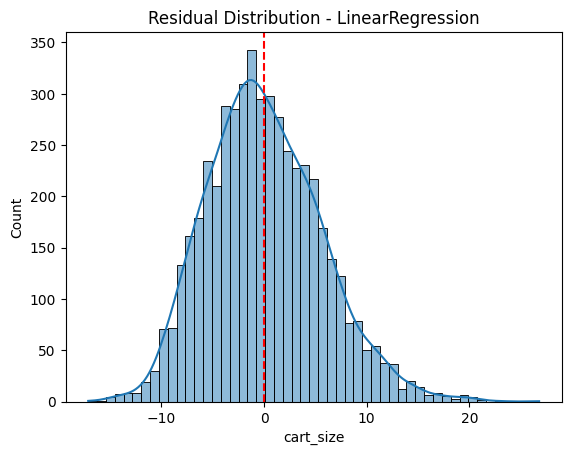

Model Coefficients:


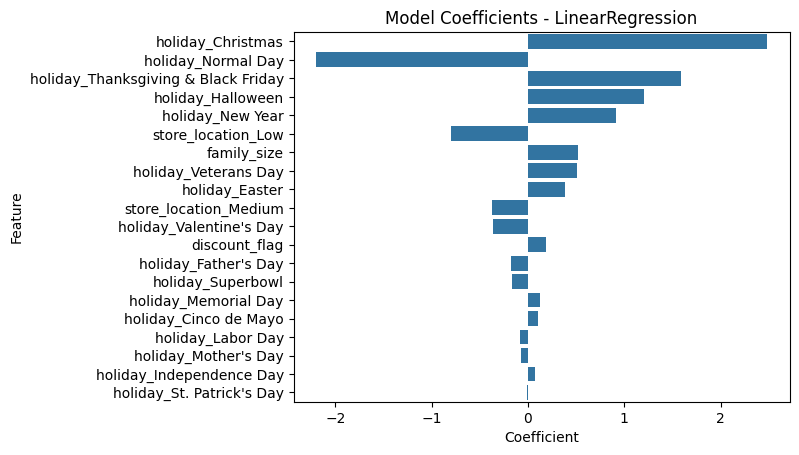

In [27]:
# linear Regression

model_fit(LinearRegression(), X_train, X_test, y_train, y_test)

RandomForestRegressor Prediction Sample: [12.49667032 21.19190132 14.83503196  9.56998137]
Metrics
MAE: 4.46
MSE: 31.52
RMSE: 5.614


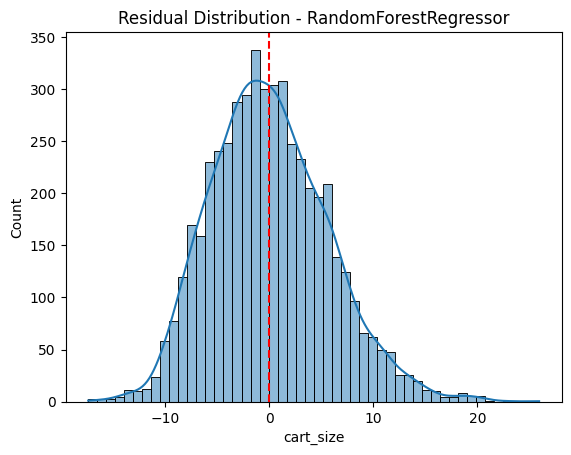

Feature Importances:


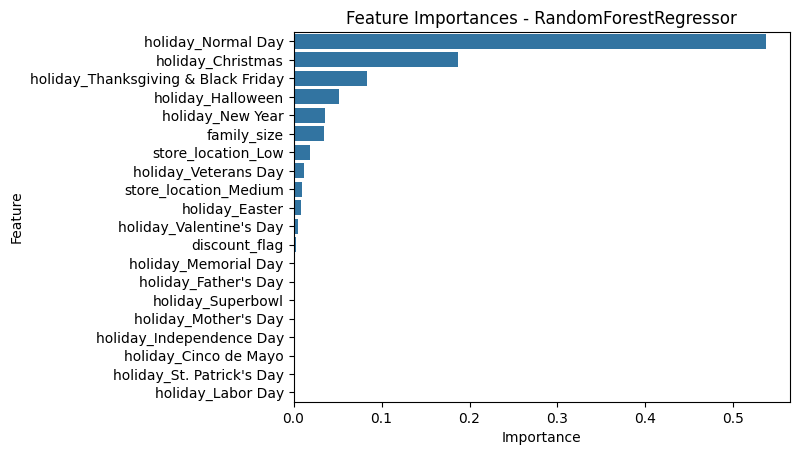

In [28]:
# Random Forest

model_fit(RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test)

XGBRegressor Prediction Sample: [12.445454 21.20012  15.656587  9.561194]
Metrics
MAE: 4.44
MSE: 31.13
RMSE: 5.579


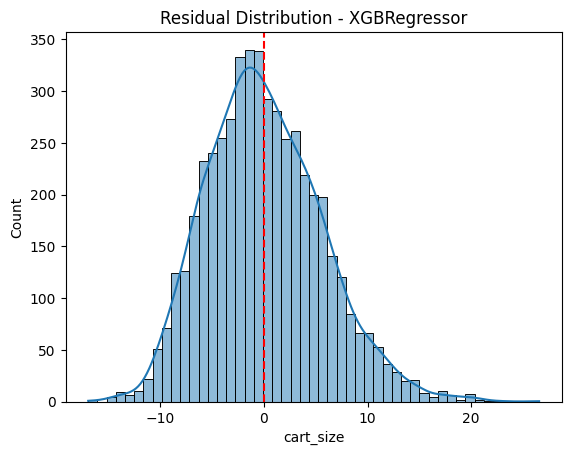

Feature Importances:


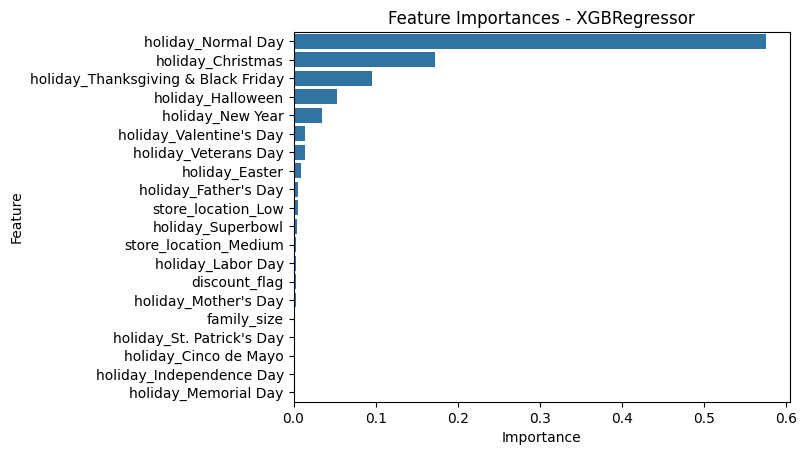

In [29]:
# XGB Regressor

model_fit(XGBRegressor(n_estimators=100, 
                       learning_rate=0.1, 
                       max_depth=3, 
                       random_state=42,
                       n_jobs=-1, 
                       verbosity=0), X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 20
[LightGBM] [Info] Start training from score 14.728350
LGBMRegressor Prediction Sample: [12.38181653 21.26693389 15.1655325   9.57328746]
Metrics
MAE: 4.45
MSE: 31.26
RMSE: 5.591


C:\Users\shrav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


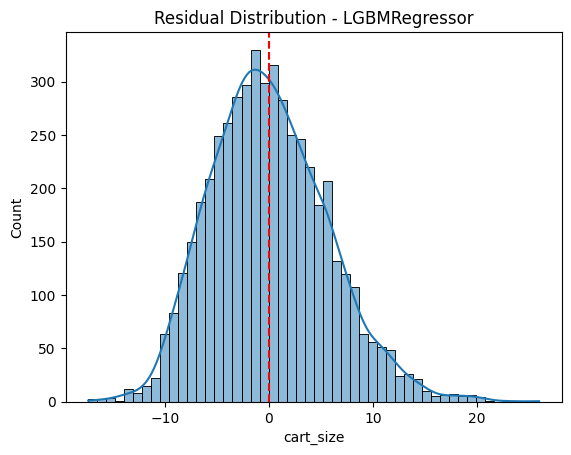

Feature Importances:


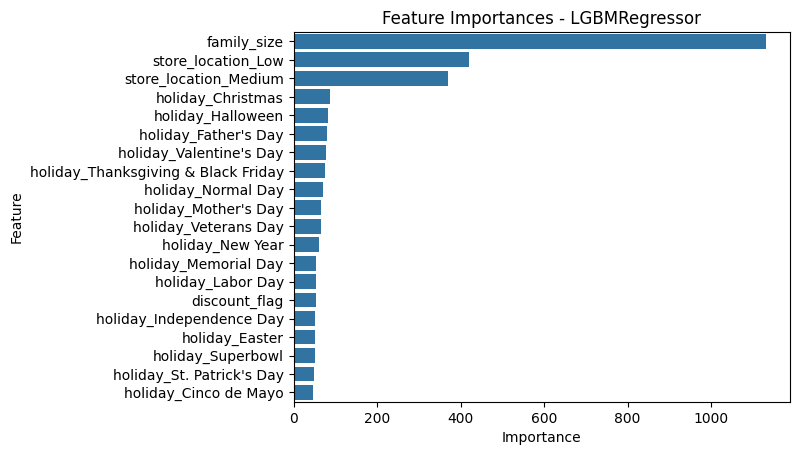

In [30]:
# LGBM Regressor

model_fit(LGBMRegressor(n_estimators=100, 
                        learning_rate=0.1, 
                        max_depth=-1, 
                        random_state=42), X_train, X_test, y_train, y_test)